# Group 42 - COMP34812



**Task A :** Natural Language Inference (NLI)

*Given a premise and a hypothesis, determine if the hypothesis is true based on the
premise. You will be given more than 26K premise-hypothesis pairs as training data, and
more than 6K pairs as validation data.*

**Solution C :** Deep learning-based approaches underpinned by transformer architectures

*Our final model used an ensemble approach where predictions from three transformer models T5, RoBERTa, and FlanT5 are combined using hard voting. These pre-trained models underwent fine-tuning and transfer learning with the dataset to improve their performance, as well as adding a BiLSTM layer to the classification head. Leveraging these pre-trained models as a starting point for training on the dataset will result in faster convergence and improved performance.*

**Group 42 :** Aisha Wahid & Libby Walton

## Prepare

This notebook requires a legacy version of tensorflow

In [38]:
import os

#We require a legacy version of tensorflow
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np

%env TF_USE_LEGACY_KERAS=1
import tensorflow as tf

env: TF_USE_LEGACY_KERAS=1


### Load Dataset

In [39]:
from google.colab import drive
drive.mount('/content/GoogleDrive')

Drive already mounted at /content/GoogleDrive; to attempt to forcibly remount, call drive.mount("/content/GoogleDrive", force_remount=True).


In [40]:
import pandas as pd

train_df = pd.read_csv('/content/GoogleDrive/MyDrive/NLU_Model/train.csv')
dev_df = pd.read_csv('/content/GoogleDrive/MyDrive/NLU_Model/dev.csv')
dev_df['hypothesis'] = dev_df['hypothesis'].astype(str)

### Model Evaluation Functions

In [73]:
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, accuracy_score, confusion_matrix
import seaborn as sns
# Evaluation function to measure model performance on the same metrics as in EvalAI
def evaluate(actual, predicted):
  accuracy = accuracy_score(actual, predicted)
  print(f"Accuracy: {accuracy}")
  report = classification_report(actual,predicted)
  print(f"Classification report: {report}")
  f1_macro = f1_score(actual,predicted,average='macro')
  print(f"F1 score - macro:, {f1_macro}")
  precision_macro = precision_score(actual,predicted,average='macro')
  print(f"Precision - macro: {precision_macro}")
  recall_macro = recall_score(actual,predicted,average='macro')
  print(f"Recall - macro: {recall_macro}")
  f1_weighted = f1_score(actual, predicted, average='weighted')
  print(f"F1 score (weighted): {f1_weighted}")
  precision_weighted = precision_score(actual, predicted, average='weighted')
  print(f"Precision (weighted): {precision_weighted}")
  recall_weighted = recall_score(actual, predicted, average='weighted')
  print(f"Recall (weighted): {recall_weighted}")
  labels =[0,1]
  cm = confusion_matrix(actual, predicted)
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, cmap="Blues", fmt='g', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

In [56]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

### Preprocessing

Preprocessing reduces the performance so was not used

In [ ]:
'''nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def preprocess(column):
  column = column.str.lower()
  column = column.str.replace(r'[^\w\s]', '', regex=True)
  column = column.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
  column =  column = column.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
  return column'''

## Model Training

### BERT

Experimented with BERT however reduced overall performance so was not used in the final ensemble

BERT Tokeniser

In [44]:
import tensorflow as tf
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def bert_encode(hypotheses, premises, tokenizer, max_length=120):

    concatenated_inputs = [h + ' [SEP] ' + p for h, p in zip(np.array(hypotheses), np.array(premises))]

    inputs = tokenizer(
        concatenated_inputs,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

    return {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'input_segment_ids': inputs['token_type_ids']
    }

train_input_bert = bert_encode(train_df.premise.values, train_df.hypothesis.values, tokenizer)

dev_input_bert = bert_encode(dev_df.premise.values, dev_df.hypothesis.values, tokenizer)

Fine Tuning Model On Our Dataset

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import transformers

max_length = 120

num_classes = 2

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_df.label.values, num_classes=num_classes)
dev_labels = tf.keras.utils.to_categorical(dev_df.label.values, num_classes=num_classes)

input_word_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
input_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")
input_segment_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_segment_ids")

# Loading pretrained BERT
bert_model = transformers.TFBertModel.from_pretrained("bert-base-cased", from_pt=True)
bert_model.trainable = True
bert_output = bert_model(
        input_word_ids, attention_mask=input_mask, token_type_ids=input_segment_ids
    )
sequence_output = bert_output.last_hidden_state

bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(sequence_output) # Adding BiLSTM
avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm) # Applying hybrid pooling
max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
concat = tf.keras.layers.concatenate([avg_pool, max_pool])
dropout = tf.keras.layers.Dropout(0.3)(concat) # Adding Dropout Layer
output_class = tf.keras.layers.Dense(units=2, activation='sigmoid')(dropout) # Adding Classification Layer
model_bert = tf.keras.models.Model(inputs=[input_word_ids, input_mask, input_segment_ids], outputs=output_class)

model_bert.compile(
        optimizer=tf.keras.optimizers.SGD(lr=1e-6),
        loss="categorical_crossentropy",
        metrics=["acc"],
    )

model_bert.fit(train_input_bert, train_labels,
          validation_data=(dev_input_bert, dev_labels),
          epochs=10,
          batch_size=32,
          verbose=1)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Epoch 1/10


842/842 [==============================] - 380s 406ms/step - loss: 0.5815 - acc: 0.6846 - val_loss: 0.4715 - val_acc: 0.7732
Epoch 2/10
842/842 [==============================] - 332s 394ms/step - loss: 0.4491 - acc: 0.7899 - val_loss: 0.4194 - val_acc: 0.8093
Epoch 3/10
842/842 [==============================] - 332s 394ms/step - loss: 0.3765 - acc: 0.8326 - val_loss: 0.4113 - val_acc: 0.8188
Epoch 4/10
842/842 [==============================] - 332s 394ms/step - loss: 0.3122 - acc: 0.8661 - val_loss: 0.4178 - val_acc: 0.8214
Epoch 5/10
842/842 [==============================] - 332s 394ms/step - loss: 0.2534 - acc: 0.8969 - val_loss: 0.4305 - val_acc: 0.8188
Epoch 6/10
842/842 [==============================] - 332s 394ms/step - loss: 0.2010 - acc: 0.9201 - val_loss: 0.4372 - val_acc: 0.8198
Epoch 7/10
842/842 [==============================] - 332s 395ms/step - loss: 0.1592 - acc: 0.9376 - val_loss: 0.5138 - val_acc: 0.8198
Epoch 8/10
842/842 [==============================] - 333s 

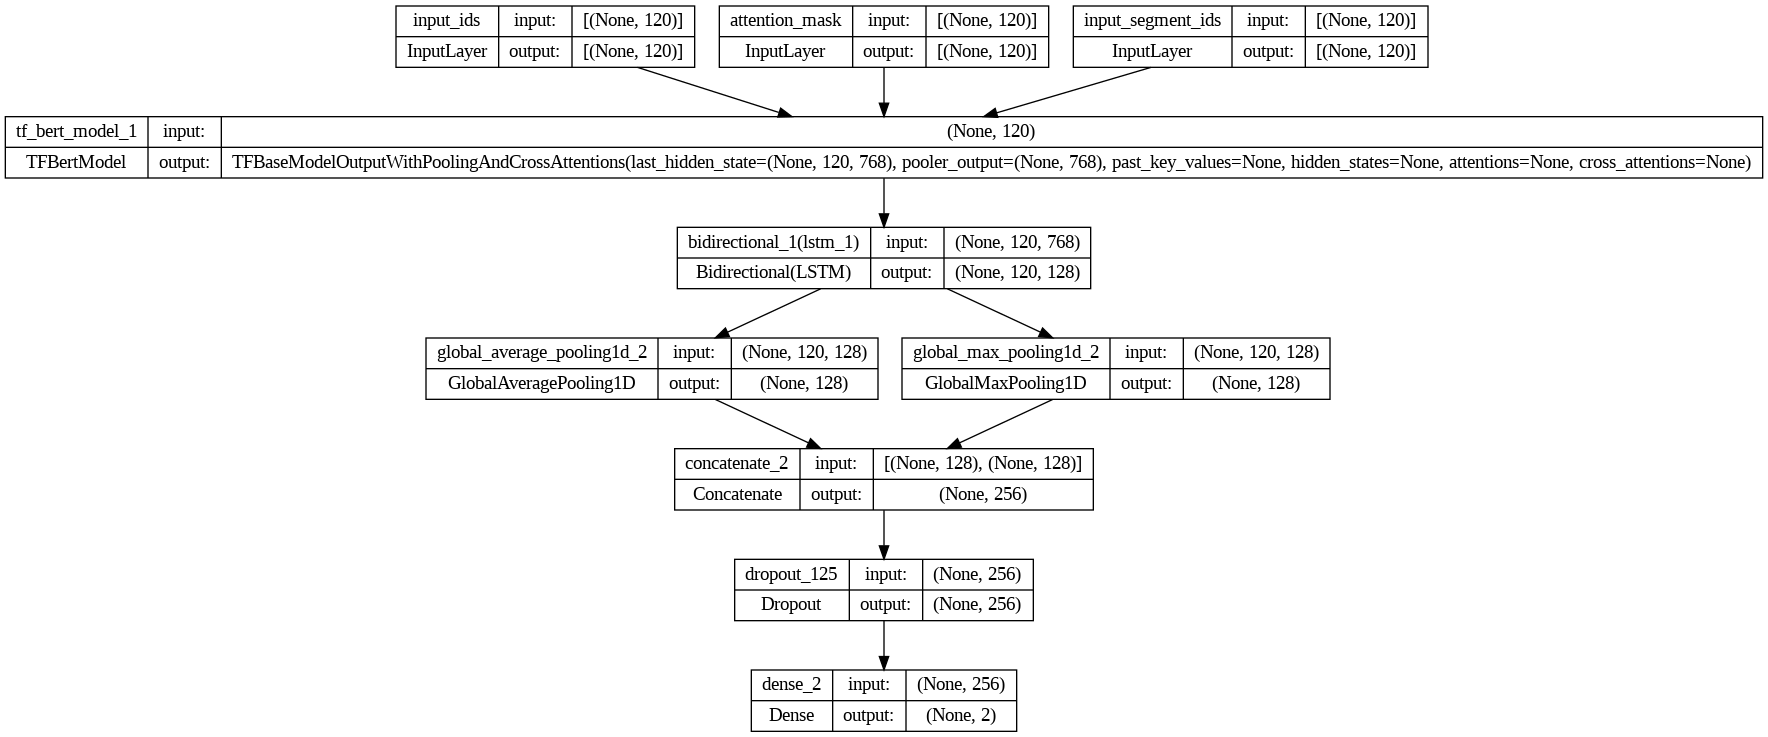

In [ ]:
tf.keras.utils.plot_model(model_bert, show_shapes=True)

### RoBERTa

RoBERTa Tokeniser

In [79]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def roberta_encode(hypotheses, premises, tokenizer, max_length=120):

    concatenated_inputs = [h + ' </s> ' + p for h, p in zip(np.array(hypotheses), np.array(premises))]

    inputs = tokenizer(
        concatenated_inputs,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

    return {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask']
    }

train_input_Roberta = roberta_encode(train_df.premise.values, train_df.hypothesis.values, tokenizer)

dev_input_Roberta = roberta_encode(dev_df.premise.values, dev_df.hypothesis.values, tokenizer)

Fine Tuning Model On Our Dataset

In [82]:
import tensorflow as tf
import transformers
import numpy as np

max_length = 120

num_classes = 2

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_df.label.values, num_classes=num_classes)
dev_labels = tf.keras.utils.to_categorical(dev_df.label.values, num_classes=num_classes)

input_word_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
input_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

# Loading pretrained RoBERTa model
roberta_model = transformers.TFRobertaModel.from_pretrained("roberta-base")
roberta_model.trainable = True
roberta_output = roberta_model(input_word_ids, attention_mask=input_mask)
sequence_output = roberta_output.last_hidden_state

# Adding BiLSTM layer
bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(sequence_output)
avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm) # Applying hybrid pooling
max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
concat = tf.keras.layers.concatenate([avg_pool, max_pool])
dropout = tf.keras.layers.Dropout(0.3)(concat)
output_class = tf.keras.layers.Dense(units=num_classes, activation='sigmoid')(dropout)

model_roberta = tf.keras.models.Model(inputs=[input_word_ids, input_mask], outputs=output_class)

model_roberta.compile(
        optimizer=tf.keras.optimizers.SGD(lr=1e-5),
        loss="categorical_crossentropy",
        metrics=["acc"],
    )

model_roberta.fit(train_input_Roberta, train_labels,
          validation_data=(dev_input_Roberta, dev_labels),
          epochs=8,
          batch_size=32,
          verbose=1)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Epoch 1/8


842/842 [==============================] - 378s 405ms/step - loss: 0.7053 - acc: 0.5038 - val_loss: 0.6830 - val_acc: 0.5946
Epoch 2/8
842/842 [==============================] - 332s 394ms/step - loss: 0.5639 - acc: 0.7090 - val_loss: 0.4442 - val_acc: 0.8056
Epoch 3/8
842/842 [==============================] - 332s 394ms/step - loss: 0.4290 - acc: 0.8098 - val_loss: 0.3544 - val_acc: 0.8501
Epoch 4/8
842/842 [==============================] - 332s 394ms/step - loss: 0.3609 - acc: 0.8437 - val_loss: 0.3417 - val_acc: 0.8563
Epoch 5/8
842/842 [==============================] - 332s 394ms/step - loss: 0.3186 - acc: 0.8662 - val_loss: 0.3222 - val_acc: 0.8609
Epoch 6/8
842/842 [==============================] - 332s 394ms/step - loss: 0.2716 - acc: 0.8891 - val_loss: 0.3426 - val_acc: 0.8611
Epoch 7/8
842/842 [==============================] - 332s 394ms/step - loss: 0.2362 - acc: 0.9035 - val_loss: 0.3658 - val_acc: 0.8603
Epoch 8/8
842/842 [==============================] - 332s 394ms/s

In [84]:
predictions = [np.argmax(i) for i in model_roberta.predict(dev_input_Roberta)]
accuracy = np.mean(predictions == dev_df.label.values)
print("Roberta Accuracy:", accuracy)

211/211 [==============================] - 35s 119ms/step
Roberta Accuracy: 0.8662609470090544


In [85]:
# Save the models to Google Drive
model_roberta.save("/content/GoogleDrive/MyDrive/NLU_Model/Roberta_model_86p63.h5")

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


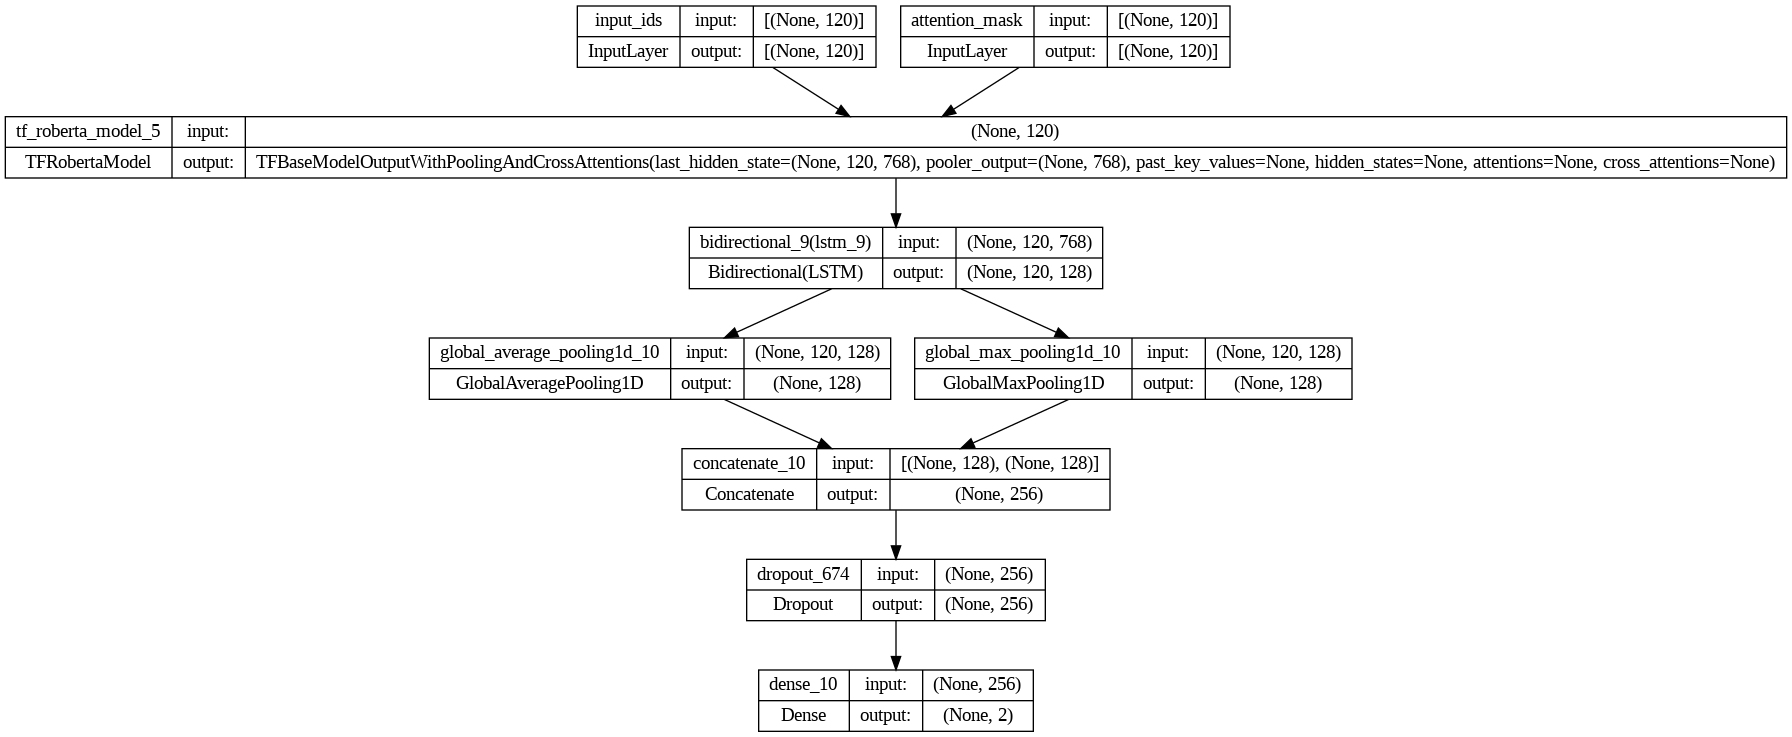

In [86]:
tf.keras.utils.plot_model(model_roberta, show_shapes=True)

### T5

T5 Tokeniser

In [49]:
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-base")

def t5_encode(hypotheses, premises, tokenizer, max_length=120):

    concatenated_inputs = [h + ' [SEP] ' + p for h, p in zip(np.array(hypotheses), np.array(premises))]

    inputs = tokenizer(
        concatenated_inputs,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

    return {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask']
    }

train_input_t5 = t5_encode(train_df.premise.values, train_df.hypothesis.values, tokenizer)

dev_input_t5 = t5_encode(dev_df.premise.values, dev_df.hypothesis.values, tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:246: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on google-t5/t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Fine Tuning Model On Our Dataset

In [51]:
from transformers import TFT5EncoderModel

max_length = 120
num_classes = 2

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_df.label.values, num_classes=num_classes)
dev_labels = tf.keras.utils.to_categorical(dev_df.label.values, num_classes=num_classes)

input_word_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
input_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

t5_model = TFT5EncoderModel.from_pretrained("google-t5/t5-base", from_pt=True)
t5_model.trainable = True
t5_output = t5_model(
        input_ids=input_word_ids, attention_mask=input_mask
    )
sequence_output = t5_output.last_hidden_state

bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(sequence_output)

avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
concat = tf.keras.layers.concatenate([avg_pool, max_pool])
dropout = tf.keras.layers.Dropout(0.3)(concat)
output_class = tf.keras.layers.Dense(units=2, activation='sigmoid')(dropout)
model_t5 = tf.keras.models.Model(inputs=[input_word_ids, input_mask], outputs=output_class)

model_t5.compile(
        optimizer=tf.keras.optimizers.SGD(lr=1e-5),
        loss="categorical_crossentropy",
        metrics=["acc"],
    )

history_t5 = model_t5.fit(train_input_t5, train_labels,
          validation_data=(dev_input_t5, dev_labels),
          epochs=10,
          batch_size=32,
          verbose=1)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFT5EncoderModel: ['decoder.block.3.layer.2.layer_norm.weight', 'decoder.block.4.layer.0.SelfAttention.o.weight', 'decoder.block.7.layer.1.EncDecAttention.k.weight', 'decoder.block.4.layer.1.EncDecAttention.k.weight', 'decoder.block.5.layer.1.EncDecAttention.v.weight', 'decoder.block.9.layer.0.SelfAttention.q.weight', 'decoder.block.5.layer.1.layer_norm.weight', 'decoder.final_layer_norm.weight', 'decoder.block.5.layer.2.layer_norm.weight', 'decoder.block.9.layer.1.layer_norm.weight', 'decoder.block.8.layer.0.SelfAttention.k.weight', 'decoder.block.11.layer.1.EncDecAttention.q.weight', 'decoder.block.5.layer.0.SelfAttention.q.weight', 'decoder.block.2.layer.0.SelfAttention.o.weight', 'decoder.block.5.layer.0.layer_norm.weight', 'decoder.block.9.layer.1.EncDecAttention.v.weight', 'decoder.block.11.layer.2.DenseReluDense.wi.weight', 'decoder.block.5.layer.1.EncDecAttention.q.weight', 'decoder.block.0.layer

Epoch 1/10
842/842 [==============================] - 310s 335ms/step - loss: 0.6850 - acc: 0.5534 - val_loss: 0.6437 - val_acc: 0.5994
Epoch 2/10
842/842 [==============================] - 272s 323ms/step - loss: 0.5317 - acc: 0.7307 - val_loss: 0.4325 - val_acc: 0.8035
Epoch 3/10
842/842 [==============================] - 273s 324ms/step - loss: 0.4221 - acc: 0.8092 - val_loss: 0.3750 - val_acc: 0.8437
Epoch 4/10
842/842 [==============================] - 273s 324ms/step - loss: 0.3682 - acc: 0.8420 - val_loss: 0.3481 - val_acc: 0.8557
Epoch 5/10
842/842 [==============================] - 273s 324ms/step - loss: 0.3334 - acc: 0.8579 - val_loss: 0.3486 - val_acc: 0.8523
Epoch 6/10
842/842 [==============================] - 273s 324ms/step - loss: 0.3039 - acc: 0.8751 - val_loss: 0.3463 - val_acc: 0.8522
Epoch 7/10
842/842 [==============================] - 273s 324ms/step - loss: 0.2825 - acc: 0.8835 - val_loss: 0.3421 - val_acc: 0.8637
Epoch 8/10
842/842 [============================

In [52]:
# Save the models to Google Drive
model_t5.save("/content/GoogleDrive/MyDrive/NLU_Model/T5_model_86p73.h5")

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


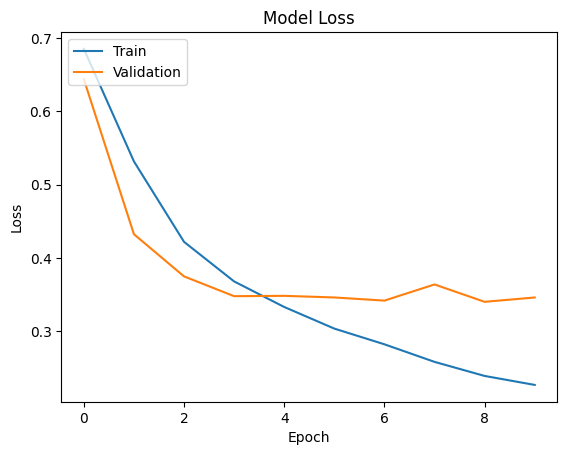

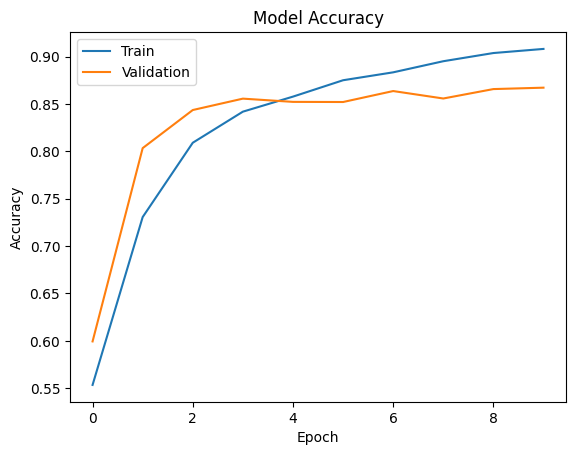

In [57]:
plot_history(history_t5)

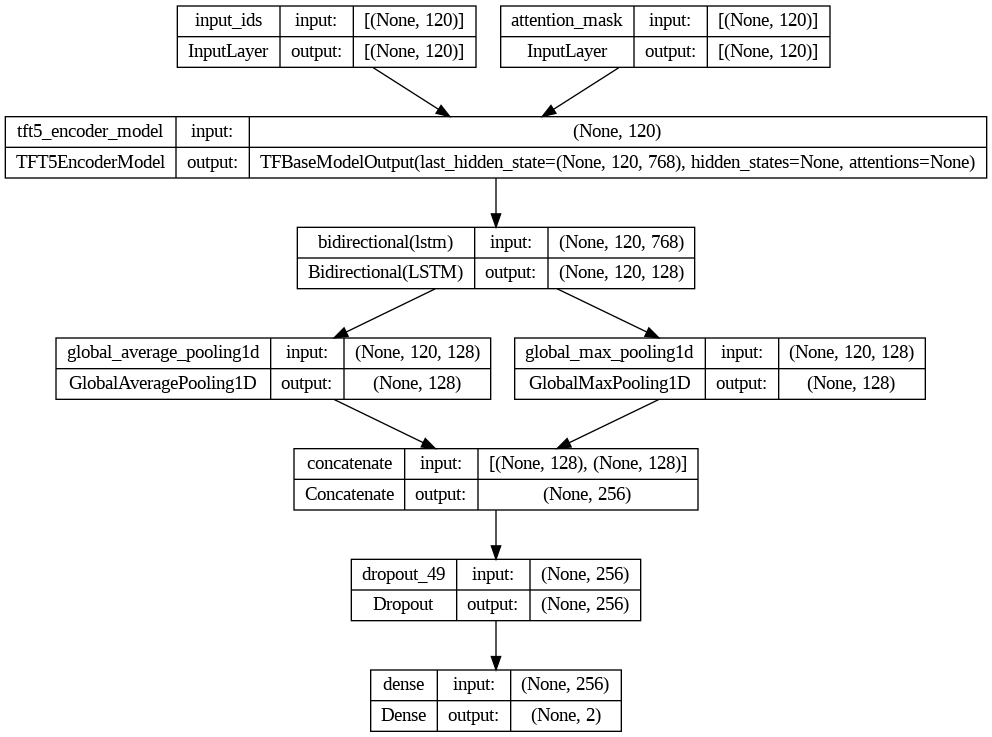

In [ ]:
tf.keras.utils.plot_model(model_t5, show_shapes=True)

### FlanT5

Flan-T5 Tokeniser

In [58]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")

def flan_t5_encode(hypotheses, premises, tokenizer, max_length=120):

    concatenated_inputs = [h + ' [SEP] ' + p for h, p in zip(np.array(hypotheses), np.array(premises))]

    inputs = tokenizer(
        concatenated_inputs,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

    return {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask']
    }

train_input_flan = flan_t5_encode(train_df.premise.values, train_df.hypothesis.values, tokenizer)

dev_input_flan = flan_t5_encode(dev_df.premise.values, dev_df.hypothesis.values, tokenizer)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Fine Tuning model on the dataset

In [59]:
from transformers import TFT5EncoderModel

max_length = 120

num_classes = 2

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_df.label.values, num_classes=num_classes)
dev_labels = tf.keras.utils.to_categorical(dev_df.label.values, num_classes=num_classes)

input_word_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
input_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

t5_model = TFT5EncoderModel.from_pretrained("google/flan-t5-base", from_pt=True)
t5_model.trainable = True
t5_output = t5_model(
        input_ids=input_word_ids, attention_mask=input_mask
    )
sequence_output = t5_output.last_hidden_state

# Adding BiLSTM
bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(sequence_output)

# Applying hybrid pooling
avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
concat = tf.keras.layers.concatenate([avg_pool, max_pool])
dropout = tf.keras.layers.Dropout(0.3)(concat)
output_class = tf.keras.layers.Dense(units=2, activation='sigmoid')(dropout)
model_flan = tf.keras.models.Model(inputs=[input_word_ids, input_mask], outputs=output_class)

model_flan.compile(
        optimizer=tf.keras.optimizers.SGD(lr=1e-5),
        loss="categorical_crossentropy",
        metrics=["acc"],
    )

model_flan.fit(train_input_flan, train_labels,
          validation_data=(dev_input_flan, dev_labels),
          epochs=10,
          batch_size=32,
          verbose=1)

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFT5EncoderModel: ['decoder.block.3.layer.2.layer_norm.weight', 'decoder.block.4.layer.0.SelfAttention.o.weight', 'decoder.block.4.layer.1.EncDecAttention.k.weight', 'decoder.block.5.layer.1.EncDecAttention.v.weight', 'decoder.block.7.layer.1.EncDecAttention.k.weight', 'decoder.block.9.layer.0.SelfAttention.q.weight', 'decoder.block.5.layer.1.layer_norm.weight', 'decoder.block.1.layer.2.DenseReluDense.wi_0.weight', 'decoder.final_layer_norm.weight', 'decoder.block.5.layer.2.layer_norm.weight', 'decoder.block.9.lay

Epoch 1/10
842/842 [==============================] - 358s 388ms/step - loss: 0.6069 - acc: 0.6478 - val_loss: 0.3596 - val_acc: 0.8532
Epoch 2/10
842/842 [==============================] - 318s 377ms/step - loss: 0.3881 - acc: 0.8312 - val_loss: 0.3198 - val_acc: 0.8716
Epoch 3/10
842/842 [==============================] - 318s 377ms/step - loss: 0.3475 - acc: 0.8525 - val_loss: 0.3046 - val_acc: 0.8784
Epoch 4/10
842/842 [==============================] - 318s 377ms/step - loss: 0.3210 - acc: 0.8662 - val_loss: 0.3132 - val_acc: 0.8768
Epoch 5/10
842/842 [==============================] - 318s 377ms/step - loss: 0.3025 - acc: 0.8723 - val_loss: 0.3009 - val_acc: 0.8842
Epoch 6/10
842/842 [==============================] - 318s 377ms/step - loss: 0.2910 - acc: 0.8801 - val_loss: 0.3069 - val_acc: 0.8824
Epoch 7/10
842/842 [==============================] - 318s 377ms/step - loss: 0.2821 - acc: 0.8832 - val_loss: 0.2836 - val_acc: 0.8882
Epoch 8/10
842/842 [============================

In [60]:
# Save the models to Google Drive
model_flan.save("/content/GoogleDrive/MyDrive/NLU_Model/T5_flan_model_88p50.h5")

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


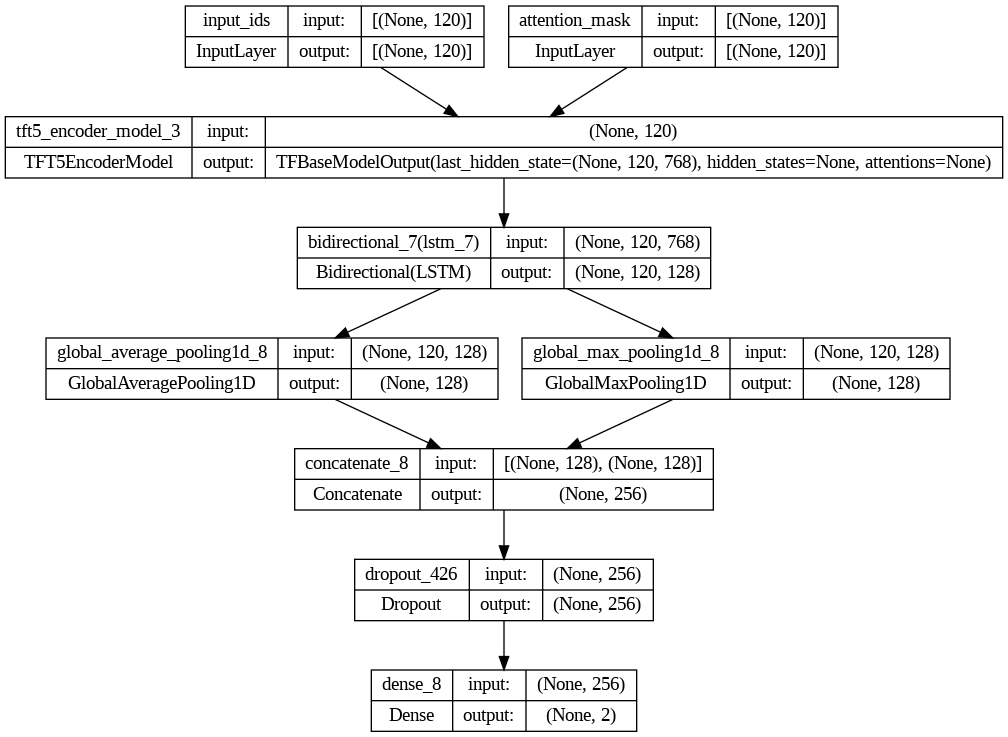

In [61]:
tf.keras.utils.plot_model(model_flan, show_shapes=True)

## Ensemble

### Tokenisers

If you want to run the ensemble from the models linked in the readme from the Google Drive, then tokenisers need to be reloaded here

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-base")

def t5_encode(hypotheses, premises, tokenizer, max_length=120):

    concatenated_inputs = [h + ' [SEP] ' + p for h, p in zip(np.array(hypotheses), np.array(premises))]

    inputs = tokenizer(
        concatenated_inputs,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

    return {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask']
    }

train_input_t5 = t5_encode(train_df.premise.values, train_df.hypothesis.values, tokenizer)

dev_input_t5 = t5_encode(dev_df.premise.values, dev_df.hypothesis.values, tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:246: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on google-t5/t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def roberta_encode(hypotheses, premises, tokenizer, max_length=120):

    concatenated_inputs = [h + ' </s> ' + p for h, p in zip(np.array(hypotheses), np.array(premises))]

    inputs = tokenizer(
        concatenated_inputs,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

    return {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask']
    }

train_input_Roberta = roberta_encode(train_df.premise.values, train_df.hypothesis.values, tokenizer)

dev_input_Roberta = roberta_encode(dev_df.premise.values, dev_df.hypothesis.values, tokenizer)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")

def flan_t5_encode(hypotheses, premises, tokenizer, max_length=120):

    concatenated_inputs = [h + ' [SEP] ' + p for h, p in zip(np.array(hypotheses), np.array(premises))]

    inputs = tokenizer(
        concatenated_inputs,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

    return {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask']
    }

train_input_flan = flan_t5_encode(train_df.premise.values, train_df.hypothesis.values, tokenizer)

dev_input_flan = flan_t5_encode(dev_df.premise.values, dev_df.hypothesis.values, tokenizer)

### Load Models

After hyperparameter tuning and evaluation, the best performing models were saved on the Google Drive. If you want to run the ensemble with these models please download the models as linked in the readme from the Google Drive and adjust paths as needed. Alternatively you can train each model using the code above in **Model Training**, however please note that the models took approximately 3 hours to train on a L4 GPU.

In [87]:
import transformers

model_roberta = tf.keras.models.load_model('/content/GoogleDrive/MyDrive/NLU_Model/Roberta_model_86p63.h5', custom_objects={"TFRobertaModel": transformers.TFRobertaModel})
model_t5 = tf.keras.models.load_model('/content/GoogleDrive/MyDrive/NLU_Model/T5_model_86p82.h5', custom_objects={"TFT5EncoderModel": transformers.TFT5EncoderModel})
model_flan = tf.keras.models.load_model('/content/GoogleDrive/MyDrive/NLU_Model/T5_flan_model_88p50.h5', custom_objects={"TFT5EncoderModel": transformers.TFT5EncoderModel})

/usr/local/lib/python3.10/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


### Ensemble

In [88]:
from collections import Counter

predictionsRoBERTa = np.argmax(model_roberta.predict(dev_input_Roberta), axis=1)
predictionsT5 = np.argmax(model_t5.predict(dev_input_t5), axis=1)
predictionsT5Flan = np.argmax(model_flan.predict(dev_input_flan), axis=1)

# Hard voting
ensemble_predictions = []
for pred_t5, pred_flan, pred_roberta in zip(predictionsT5, predictionsT5Flan, predictionsRoBERTa):
    votes = Counter([pred_t5, pred_flan, pred_roberta])
    ensemble_predictions.append(votes.most_common(1)[0][0])

# Calculate accuracy
acc = np.mean(ensemble_predictions == dev_df.label.values)
print("Ensemble Accuracy:", acc)

211/211 [==============================] - 33s 109ms/step
Ensemble Accuracy: 0.8929790708030281


### Writing predicted labels to csv

In [ ]:
pd.set_option('display.max_rows', None)
result_df = pd.DataFrame({'prediction': ensemble_predictions})
column_name_row = pd.DataFrame({'prediction': ['prediction']}, index=[0])
result_df['prediction'] = result_df['prediction'].astype(int)
result_df = pd.concat([column_name_row, result_df]).reset_index(drop=True)
result_df.to_csv('ensemble-transformers.csv', encoding='utf-8', index=False, header=False)
result_df

## Evaluation

### RoBERTa

Accuracy: 0.8662609470090544
Classification report:               precision    recall  f1-score   support

           0       0.87      0.86      0.86      3259
           1       0.87      0.88      0.87      3478

    accuracy                           0.87      6737
   macro avg       0.87      0.87      0.87      6737
weighted avg       0.87      0.87      0.87      6737

F1 score - macro:, 0.8660645196594353
Precision - macro: 0.8662562231009276
Recall - macro: 0.8659310943411275
F1 score (weighted): 0.8662312545027167
Precision (weighted): 0.866259706386718
Recall (weighted): 0.8662609470090544


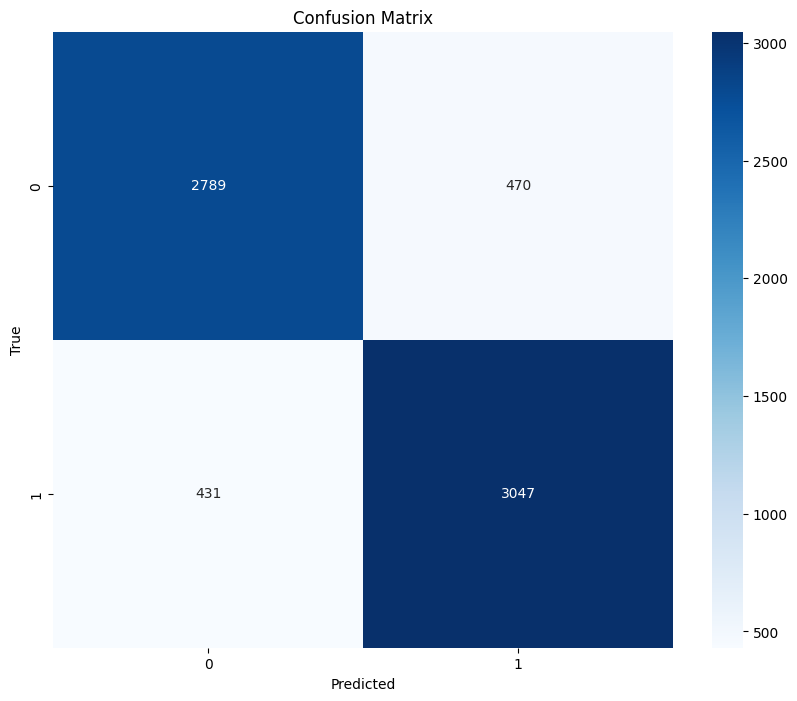

In [90]:
evaluate(dev_df.label.values, predictionsRoBERTa)

### T5

Accuracy: 0.8681905892830637
Classification report:               precision    recall  f1-score   support

           0       0.84      0.89      0.87      3259
           1       0.90      0.84      0.87      3478

    accuracy                           0.87      6737
   macro avg       0.87      0.87      0.87      6737
weighted avg       0.87      0.87      0.87      6737

F1 score - macro:, 0.8681897499894242
Precision - macro: 0.8689151028431583
Recall - macro: 0.8690268696356583
F1 score (weighted): 0.8682005620663086
Precision (weighted): 0.8697727702467298
Recall (weighted): 0.8681905892830637


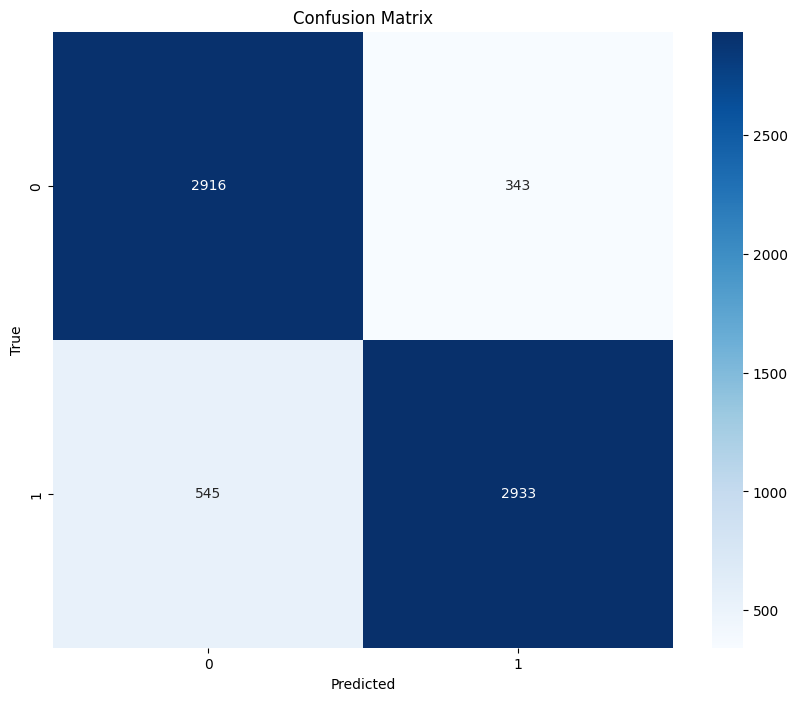

In [91]:
evaluate(dev_df.label.values, predictionsT5)

### FlanT5

Accuracy: 0.884963633664836
Classification report:               precision    recall  f1-score   support

           0       0.87      0.90      0.88      3259
           1       0.90      0.87      0.89      3478

    accuracy                           0.88      6737
   macro avg       0.88      0.89      0.88      6737
weighted avg       0.89      0.88      0.88      6737

F1 score - macro:, 0.8849246491096351
Precision - macro: 0.8849008009636734
Recall - macro: 0.8853008195467376
F1 score (weighted): 0.8849935008643849
Precision (weighted): 0.8853752961896939
Recall (weighted): 0.884963633664836


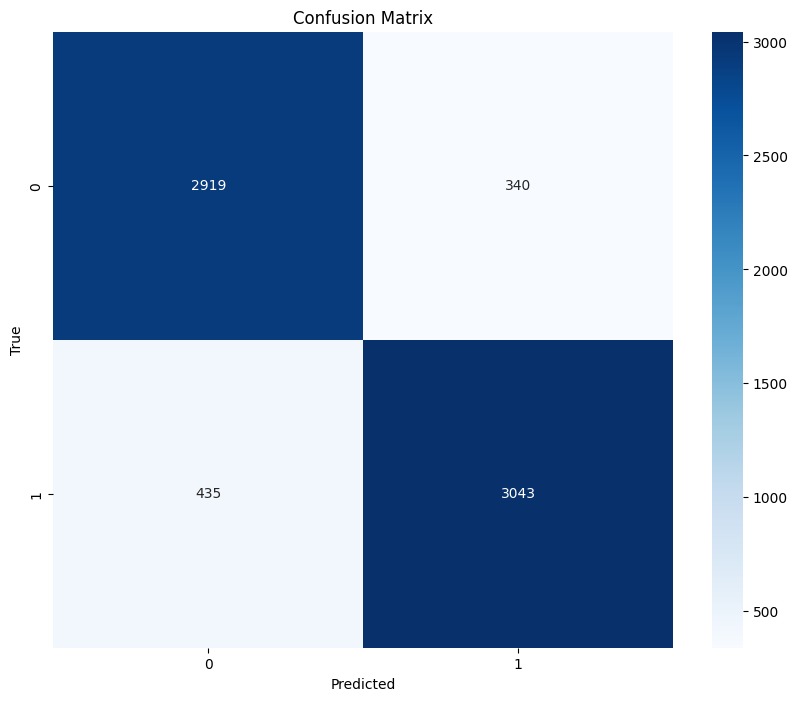

In [92]:
evaluate(dev_df.label.values, predictionsT5Flan)

### Ensemble

Accuracy: 0.8929790708030281
Classification report:               precision    recall  f1-score   support

           0       0.88      0.90      0.89      3259
           1       0.91      0.89      0.90      3478

    accuracy                           0.89      6737
   macro avg       0.89      0.89      0.89      6737
weighted avg       0.89      0.89      0.89      6737

F1 score - macro:, 0.8929301538871262
Precision - macro: 0.892853812428816
Recall - macro: 0.8932281304957952
F1 score (weighted): 0.8930045483633937
Precision (weighted): 0.8932513716165325
Recall (weighted): 0.8929790708030281


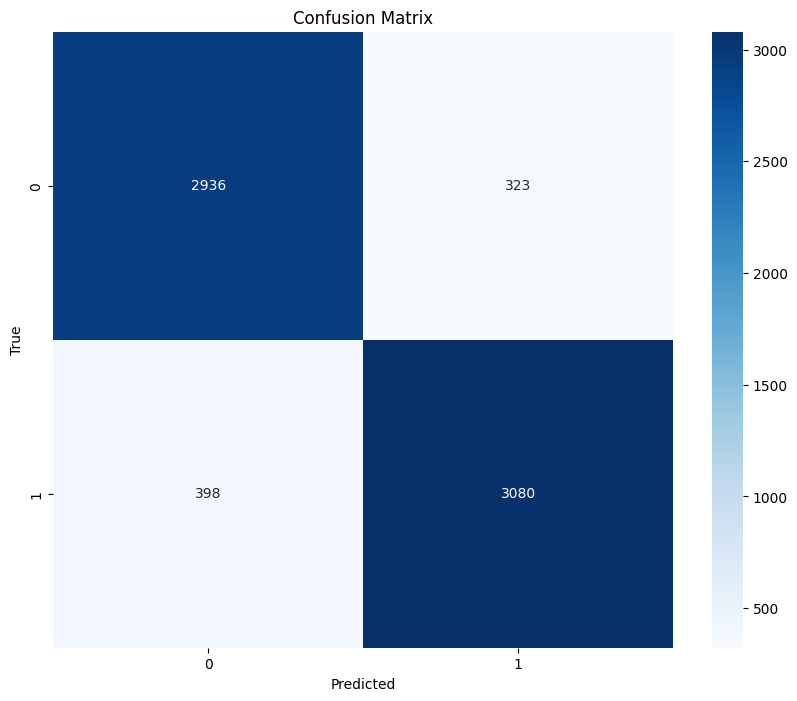

In [93]:
evaluate(dev_df.label.values, ensemble_predictions)